# Problem Statement

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

You can get the dataset here https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/

It is advised to look at the dataset after completing the hypothesis generation part.

Now that we have the dataset as well as the understanding of the problem statement, let’s look at the steps that we will follow in this course to solve the problem at hand.

## Table of Contents

a) Understanding Data:

    1) Hypothesis Generation

    2) Getting the system ready and loading the data

    3) Dataset Structure and Content

    4) Feature Extraction

    5) Exploratory Analysis

b) Forecasting using Multiple Modeling Techniques:

    1) Splitting the data into training and validation part

    2) Modeling techniques

    3) Holt’s Linear Trend Model on daily time series

    4) Holt Winter’s Model on daily time series

    5) Introduction to ARIMA model

    6) Parameter tuning for ARIMA model

    7) SARIMAX model on daily time series

We will start with the first step, i.e. Hypothesis Generation. Hypothesis Generation is the process of listing out all the possible factors that can affect the outcome.

Hypothesis generation is done before having a look at the data in order to avoid any bias that may result after the observation.

### 1) Hypothesis Generation

Hypothesis generation helps us to point out the factors which might affect our dependent variable. Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail:

    a) There will be an increase in the traffic as the years pass by.
    - Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.
    b) The traffic will be high from May to October.
    - Explanation - Tourist visits generally increases during this time perion.
    c) Traffic on weekdays will be more as compared to weekends/holidays.
    - Explanation - People will go to office on weekdays and hence the traffic will be more
    d) Traffic during the peak hours will be high.
    - Explanation - People will travel to work, college.

We will try to validate each of these hypothesis based on the dataset. Now let’s have a look at the dataset.



After making our hypothesis, we will try to validate them. Before that we will import all the necessary packages.

### 2) Getting the system ready and loading the data

Versions:

- Python = 3.7

- Pandas = 0.20.3

- sklearn = 0.19.1

Now we will import all the packages which will be used throughout the notebook.

In [1]:
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
%matplotlib inline
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

Now let’s read the train and test data

In [2]:
train=pd.read_csv("Train_SU63ISt.csv")
test=pd.read_csv("Test_0qrQsBZ.csv")

Let’s make a copy of train and test data so that even if we do changes in these dataset we do not lose the original dataset.

In [3]:
train_original=train.copy()
test_original=test.copy()

After loading the data, let’s have a quick look at the dataset to know our data better.

### 3) Dataset Structure and Content

Let’s dive deeper and have a look at the dataset. First of all let’s have a look at the features in the train and test dataset.

In [4]:
train.columns, test.columns

(Index([u'ID', u'Datetime', u'Count'], dtype='object'),
 Index([u'ID', u'Datetime'], dtype='object'))

We have ID, Datetime and corresponding count of passengers in the train file. For test file we have ID and Datetime only so we have to predict the Count for test file.

Let’s understand each feature first:

- ID is the unique number given to each observation point.
- Datetime is the time of each observation.
- Count is the passenger count corresponding to each Datetime.

Let’s look at the data types of each feature.

In [5]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

- ID and Count are in integer format while the Datetime is in object format for the train file.
- Id is in integer and Datetime is in object format for test file.

Now we will see the shape of the dataset.

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

We have 18288 different records for the Count of passengers in train set and 5112 in test set.

Now we will extract more features to validate our hypothesis.

### 4) Feature Extraction

We will extract the time and date from the Datetime. We have seen earlier that the data type of Datetime is object. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [8]:
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

In [10]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [11]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour

In [12]:
i.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

- We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

- Values of 5 and 6 represents that the days are weekend.

In [13]:
train['day of week']=train['Datetime'].dt.dayofweek
temp = train['Datetime']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [14]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

Let’s look at the time series.

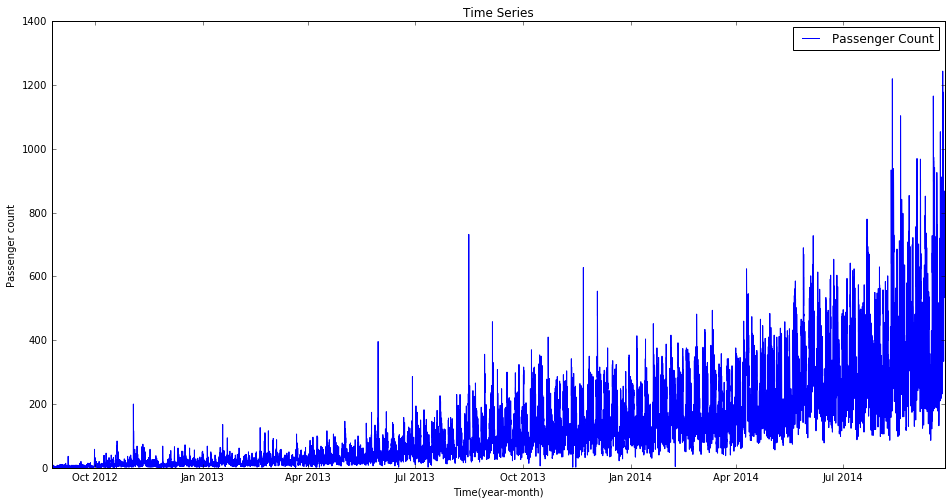

In [15]:
train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis.
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis.
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

Lets recall the hypothesis that we made earlier:

- Traffic will increase as the years pass by
- Traffic will be high from May to October
- Traffic on weekdays will be more
- Traffic during the peak hours will be high

After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset.

### 5) Exploratory Analysis

Let us try to verify our hypothesis using the actual data.

Our first hypothesis was traffic will increase as the years pass by. So let’s look at yearly passenger count.

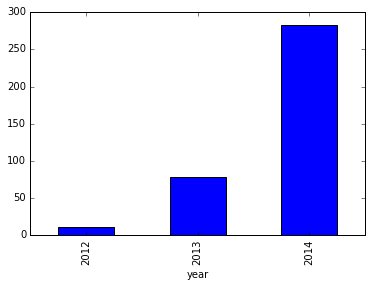

In [16]:
train.groupby('year')['Count'].mean().plot.bar()

We see an exponential growth in the traffic with respect to year which validates our hypothesis.

Our second hypothesis was about increase in traffic from May to October. So, let’s see the relation between count and month.

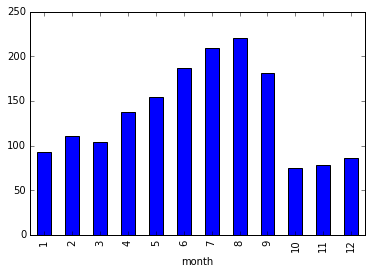

In [17]:
train.groupby('month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

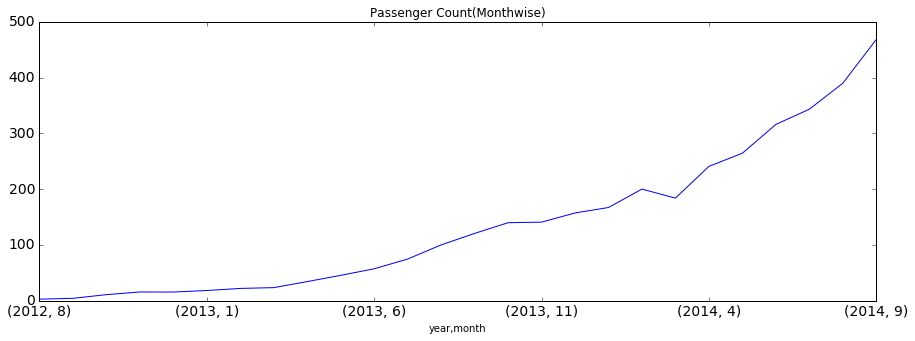

In [18]:
temp=train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

- We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.
- Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

- In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

Let’s look at the daily mean of passenger count.

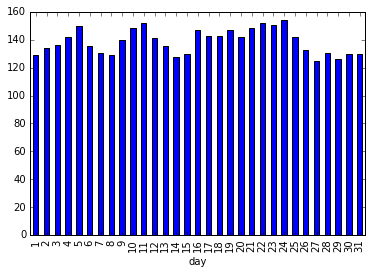

In [19]:
train.groupby('day')['Count'].mean().plot.bar()

We are not getting much insights from day wise count of the passengers.

We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

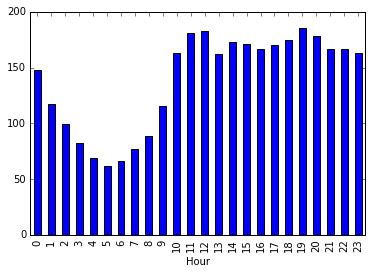

In [20]:
train.groupby('Hour')['Count'].mean().plot.bar()

- It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
- After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.

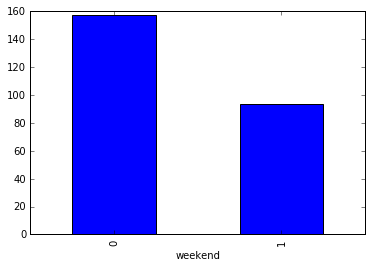

In [21]:
train.groupby('weekend')['Count'].mean().plot.bar()

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

Now we will try to look at the day wise passenger count.

Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

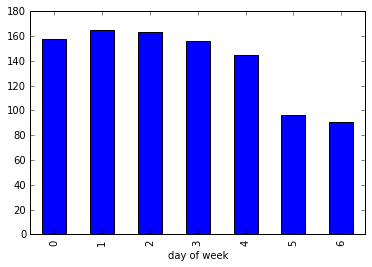

In [22]:
train.groupby('day of week')['Count'].mean().plot.bar()

From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week. Now we will look at basic modeling techniques. Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [23]:
train=train.drop('ID',1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [25]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Hourly time series
hourly = train.resample('H').mean()

# Converting to daily mean
daily = train.resample('D').mean()

# Converting to weekly mean
weekly = train.resample('W').mean()

# Converting to monthly mean
monthly = train.resample('M').mean()

Let’s look at the hourly, daily, weekly and monthly time series.

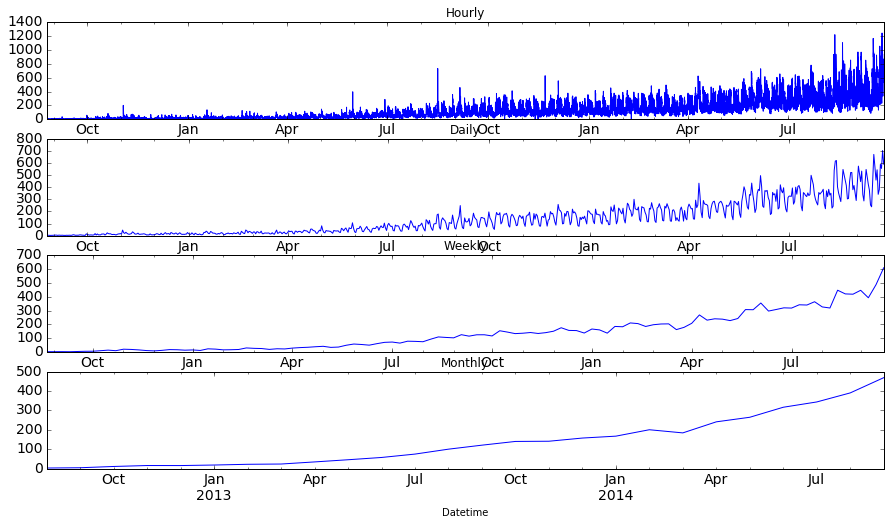

In [27]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [28]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 

# Converting to daily mean
test = test.resample('D').mean()

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

# Converting to daily mean
train = train.resample('D').mean()

## Splitting the data into training and validation part

As we have validated all our hypothesis, let’s go ahead and build models for Time Series Forecasting. But before we do that, we will need a dataset(validation) to check the performance and generalisation ability of our model. Below are some of the properties of the dataset required for the purpose.

- The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.

- The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and validate on it as well.

So, for the above two reasons, we generally divide the train dataset into two parts. One part is used to train the model and the other part is used as the validation dataset. Now there are multiple ways to divide the train dataset such as Random Division etc. You can look for all of the different validation methods here: https://www.analyticsvidhya.com/blog/2015/11/improve-model-performance-cross-validation-in-python-r/.

For this course, We will be using a time based split explained below.

### 1) Splitting the data into training and validation part

Now we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

**NOTE** - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.

In [30]:
Train=train.ix['2012-08-25':'2014-06-24']
valid=train.ix['2014-06-25':'2014-09-25']

- We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

- Lets understand it in this way: If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

Now we will look at how the train and validation part has been divided.

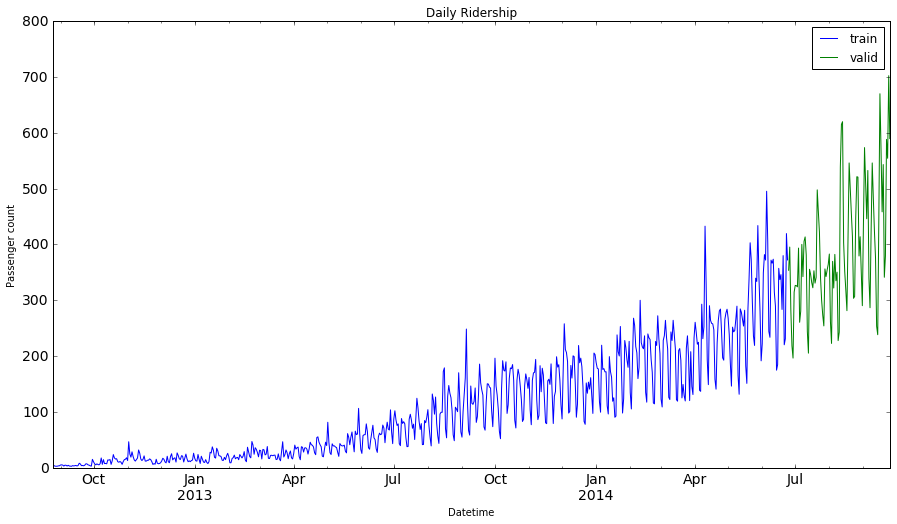

In [31]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

Here the blue part represents the train data and the orange part represents the validation data.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

### 2) Modeling techniques

We will look at various models now to forecast the time series . Methods which we will be discussing for the forecasting are:

**i) Naive Approach**

**ii) Moving Average**

**iii) Simple Exponential Smoothing**

**iv) Holt’s Linear Trend Model**

We will discuss each of these methods in detail now.

#### i) Naive Approach

- In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. Lets understand it with an example and an image:

Suppose we have passenger count for 5 days as shown below:

|Day	     |Passenger Count |
|------------|:---------------|
|1	         |      10        |
|2	         |      12        |
|3	         |      14        |
|4	         |      13        |
|5	         |      15        |

And we have to predict the passenger count for next 2 days. Naive approach will assign the 5th day’s passenger count to the 6th and 7th day, i.e., 15 will be assigned to the 6th and 7th day.

|Day	     |Passenger Count |
|------------|:--------------:|
|1           |      10        |
|2	         |      12        |
|3	         |      14        |
|4	         |      13        |
|5           |	    15        |
|6           |	    15        |
|7           |  	15        |

Now lets understand it with an example:

Example

The blue line is the prediction here. All the predictions are equal to the last observed point.

Let’s make predictions using naive approach for the validation set

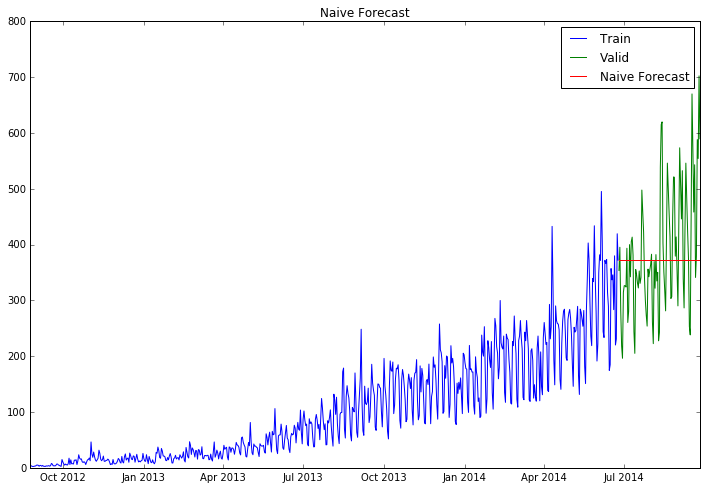

In [32]:
dd= np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

- We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
- rmse is the standard deviation of the residuals.
- Residuals are a measure of how far from the regression line data points are.
- The formula for rmse is:

rmse=sqrt∑i=1N1N(p−a)2

We will now calculate RMSE to check the accuracy of our model on validation data set.

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.790504675


We can infer that this method is not suitable for datasets with high variability. We can reduce the rmse value by adopting different techniques.

#### ii) Moving Average

In this technique we will take the average of the passenger counts for last few time periods only.

Let’s take an example to understand it:

![Example]()
Example

Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

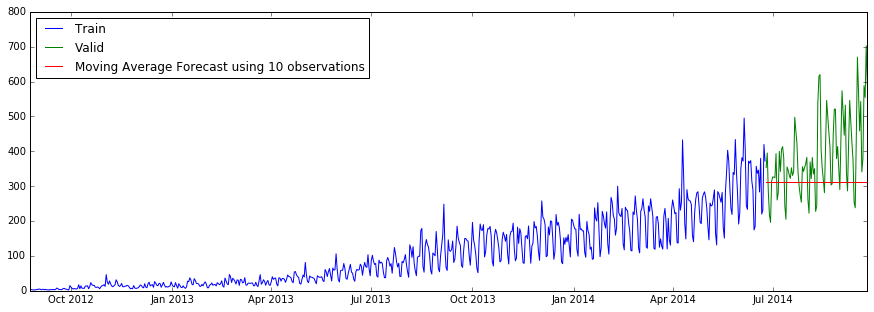

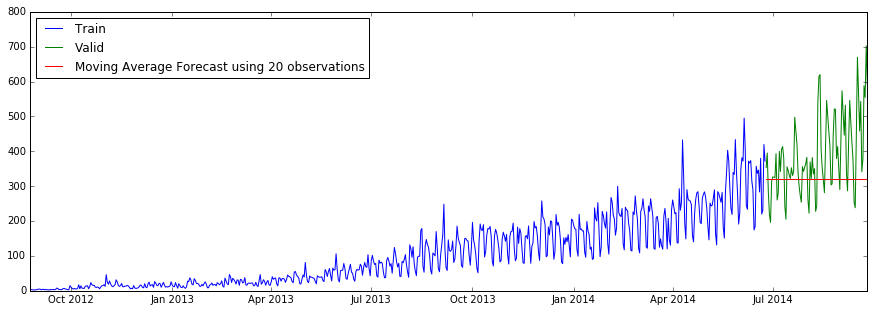

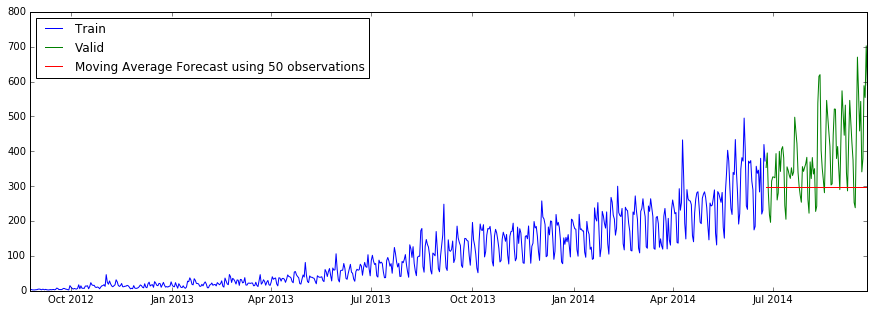

In [34]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()

We took the average of last 10, 20 and 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part. We can see that the predictions are getting weaker as we increase the number of observations.

In [35]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
print(rms)

144.1917568


#### iii) Simple Exponential Smoothing

- In this technique, we assign larger weights to more recent observations than to observations from the distant past.
- The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

**NOTE** - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

Let’s look at an example of simple exponential smoothing:

![Example](https://origin2.cdn.componentsource.com/sites/default/files/resources/dundas/538216/Documentation/images/SimpleMovingAverage.png)

Example

Here the predictions are made by assigning larger weight to the recent values and lesser weight to the old values.

In [48]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

ImportError: cannot import name ExponentialSmoothing

In [ ]:
!pip uninstall statsmodels

In [37]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))
print(rms)

AttributeError: 'DataFrame' object has no attribute 'SES'